# Tutorial: Analyze Gray Matter Volume of Brain Areas

This tutorial shows to how load and plot the volumes of gray matter areas extracted using a series of brainlife.io/apps (hereafter simply `Apps`). The `Apps` extract the volumes of the areas using a combination of FREESURFER and HCP data processes. 

Learning outcomes:
 - Understand how to import the library `pybrainlife` that is needed to load data
 - Understand what the DataType loaded contain
 - Practice with loading and addressing (indexing) the data structures
 - Learn how to generate a plot of the data structures

###### Note. 
We have [a tutorial](https://brainlife.io/docs/tutorial/t1w-preprocessing/) that walks through how to generate the data needed in this tutorial. Here we assume you have generated the data as explained in the tutorial.

## brainlife.io separates data preprocessing  from analysis

#### Data Preprocessing

brainlife.io/apps take raw (or minimally processed) data and preprocess them. Preprocessing data can vary all the way from reducing image artifacts to extracting features (such as volumes of brain areas, or fnctional connectivity or white matter tracts profiles). Data preprocessed using `Apps` can be downloaded for local analysis or analyzed futher using Jupyter notebooks hosted by brainlife.io (here after `BL-jnb`).

This is not the location to learn how to use `Apps`. Other tutorials that explain how to develop `Apps` and process data.

#### Data Analysis

brainlife.io hosts Jupyter Notebooks that allow to analyze data on the cloud. Data can be analyzed using python, R, Octave or Julia. To analyze data inside a brainlife.io hosted jupyter notebook you need to have data processed using brainlife.io/apps.

Unfortunately, not all the data processed by `Apps` is made available to `BL-jnb`. Some brainlife.io/DataTypes are defined as being useful for data analysis and are served (i.e., made available) to `BL-jnb`. The `App` developers or the person that defines the `DataType` at the time of development of the `DataType` declares the `DataType` as a feature and features are served by brainlife.io to `BL-jnb`. We explain how to define `DataTypes` 

This example notebook will guide the user through load data that has been processed on brainlife.io using 

for their project from the secondary warehouse, compiling data across the entire project, and analyzing and visualizing the compiled results on brainlife.io via the 'Analysis' tab. This example is written for python3, and uses one of the Python3 notebook types.

Within this notebook, I will guide the user through analyses comprising derivatives generated from one of the three main datatypes available on brainlife.io, specifically neuro/dwi. Specifically, I will guide the user through:
        
    1. Load sample data for parcellation statistics.
    2. doing some simple data manipulations
    3. generating simple visualizations
    
All of these functions used here are provided in a self-contained python package called "pybrainlife" [https://pypi.org/project/pybrainlife/].

First thing we'll do is load our python modules, specifically pandas, and pybrainlife!

### Import pandas and pybrainlife modules

In [6]:
import os,sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import random
from scipy.stats import ttest_ind
from example_bootstrapping_functions import bootstrap_analysis_groups,bootstrap_analysis_within_groups, plot_histogram, plot_histogram_groups, set_up_figure

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pybrainlife as pbl
from pybrainlife.data.collect import collect_data
from pybrainlife.data.collect import collect_subject_data
import pybrainlife.data.manipulate as pybldm
import pybrainlife.vis.plots as pyblvp

Next thing we'll do is we'll define some useful functions. Specifically, we will define a few fuctions to peform bootstrapping analyses on the data and plotting the histograms

### Load sample subjects data

Now that we have our modules, imported, we can load our sample datasets!

First, we will load our subjects dataframe using pandas! We will also build a column containing a color for each group.

In [8]:
### Load the subjects dataframe
## First, let's load the subjects dataframe using the collect_subject_data function in pybrainlife
## collect_subject_data():
## inputs = path where we would like to save the dataframe. if we don't want to save, just leave blank

# load the subjects data
subjects_data = collect_subject_data('subjects_data.csv')

# remove the index column just to keep things clean
subjects_data = subjects_data.drop(columns="index")

# rename the subject column to 'subjectID'
subjects_data = subjects_data.rename(columns={'subject': 'subjectID'})

# rename the diagnosis column to 'classID'
subjects_data = subjects_data.rename(columns={'diagnosis': 'classID'})

# make sure subjectID column is string
subjects_data['subjectID'] = subjects_data['subjectID'].astype(str)

### Visualize the dataframe 
## now let's visualize the dataframe to inspect
# print out a random sample of 10 rows
subjects_data.sample(10).head(10)

,subjectID,classID,age,gender,bart,bht,dwi,pamenc,pamret,rest,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
43,10487,CONTROL,31,M,1.0,1.0,1.0,,,1.0,...,0,28,0,0,0,0,1,57,0,1.04
111,11077,CONTROL,22,F,1.0,1.0,1.0,1.0,1.0,1.0,...,1,20,0,0,0,0,0,62,0,2.10
231,70004,ADHD,26,F,1.0,1.0,1.0,,,1.0,...,0,26,0,0,0,1,0,49,0,0.88
187,60014,BIPOLAR,44,F,1.0,1.0,1.0,1.0,1.0,1.0,...,0,60,0,0,1,0,1,88,0,0.47
240,70029,ADHD,24,F,1.0,1.0,1.0,1.0,1.0,1.0,...,0,56,0,0,0,0,0,74,0,0.32
236,70020,ADHD,50,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,65,0,1,2,0,0,118,0,0.82
6,10225,CONTROL,35,M,1.0,1.0,1.0,,,1.0,...,0,22,0,0,0,0,1,48,0,1.18
271,70086,ADHD,48,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,35,1,0,0,0,0,73,0,1.09
227,60087,BIPOLAR,41,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,32,0,0,0,0,0,64,0,1.00
86,10893,CONTROL,25,F,1.0,1.0,1.0,1.0,1.0,1.0,...,0,44,0,0,0,1,0,116,1,1.64


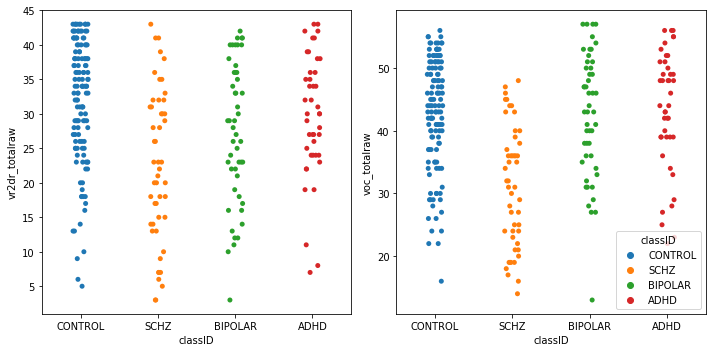

In [9]:
## compute categorical scatter plot for the left and right V1s for gray matter volume and cortical thickness
# create a subplot figure with 1 row and 2 columns
fig, axes = plt.subplots(1,2,figsize=(10,5),sharex=True)

# create a strip plot for each measure
sns.stripplot(x='classID',y='vr2dr_totalraw',data=subjects_data,hue='classID',ax=axes[0],size=5,legend=False)
sns.stripplot(x='classID',y='voc_totalraw',data=subjects_data,hue='classID',ax=axes[1],size=5)
fig.tight_layout()

### Cortical analysis
Now that we have our subjects information loaded, let's load some actual data!

For this notebook, we will load the parc-stats datatype containing all of the morphometric information for the cortical parcellations generated using the "collect_data" function from pybrainlife

In [11]:
## load parc-stats data
# function: collect_data()
# inputs: datatype = name of the datatype (example: 'parc-stats')
#         datatype_tags = list of datatype tags to search for (can leave blank for this analysis)
#         tags = list of object tags to search for (can leave blank for this analysis)
#         filename = name of the file within the datatype (you can search for this by using the File Viewer on the parc-stats datatype)
#         outPath = filepath where to save the concatenated data (can be left blank if you don't want to save the file)
#         duplicates = True or False; True = keep duplicates, False = remove duplicates

# set the output directory and output filename
output_filename = 'cortical-statistics.csv'

# if the output file doesn't exist, comb through the warehouse to find the data for the project and concatenate to single dataframe
# if it does exist, just load the dataframe
cortex_df,_,_ = collect_data(datatype='neuro/parc-stats', \
                             filename='parc-stats/merged.csv', \
                             outPath=output_filename, \
                             duplicates=True)

# make sure to set subjectID as string
cortex_df['subjectID'] = cortex_df['subjectID'].astype(str)
   
# merge subjects data frame with tractmeasures
cortex_df = cortex_df.merge(subjects_data,on='subjectID')

# visualize the dataframe
cortex_df.sample(10).head(10)

,subjectID,structureID,parcellationID,number_of_vertices,surface_area_mm^2,gray_matter_volume_mm^3,thickness,thickness_std,mean_curv,gaus_curv,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
48095,50032,rh_superiorparietal,aparc,5883,4084,10118,2.278,0.507,0.126,0.035,...,0,30,0,0,0,1,0,92,0,2.07
51864,50056,rh_cuneus,aparc,2391,1521,3208,1.922,0.452,0.129,0.033,...,0,49,0,0,1,1,0,124,0,1.53
3905,10506,lh_S_circular_insula_sup,aparc.a2009s,2000,1323,2718,2.392,0.457,0.101,0.021,...,0,24,0,0,0,0,0,67,0,1.79
35467,50085,lh_G_and_S_cingul-Mid-Post,aparc.a2009s,1221,838,2246,2.684,0.459,0.116,0.028,...,0,39,0,0,0,0,0,76,0,0.95
52298,50056,R_FFC_ROI,hcp-mmp-b,748,510,1462,2.583,0.420,0.120,0.030,...,0,49,0,0,1,1,0,124,0,1.53
10449,10478,L_47m_ROI,hcp-mmp-b,259,172,400,2.328,0.386,0.101,0.021,...,0,32,0,0,0,0,0,64,0,1.00
28228,50007,L_PFop_ROI,hcp-mmp-b,415,271,965,2.868,0.559,0.131,0.028,...,0,55,1,0,0,2,0,95,0,0.73
18020,10877,L_2_ROI,hcp-mmp-b,2180,1452,2850,2.099,0.416,0.115,0.025,...,0,32,0,0,0,0,0,53,0,0.66
31756,50067,rh_G_front_sup,aparc.a2009s,7512,5194,18710,2.891,0.596,0.127,0.034,...,0,47,0,0,0,0,0,72,0,0.53
34960,50035,rh_S_oc-temp_lat,aparc.a2009s,1148,770,1602,2.456,0.460,0.110,0.021,...,0,54,0,0,2,0,0,145,0,1.69


For this example, let's just look at cortical data from the hcp-mmp-b atlas (i.e. Glasser atlas).

To do this, we can just use some simple pandas .loc functionality to identify only those data that correspond to the hcp-mmp-b atlas

In [12]:
## subsample data for only parcels in hcp-mmp-b
cortex_df_glasser = cortex_df.loc[cortex_df['parcellationID'] == 'hcp-mmp-b'].reset_index(drop=True)

# visualize the dataframe
cortex_df_glasser.sample(10).head(10)

,subjectID,structureID,parcellationID,number_of_vertices,surface_area_mm^2,gray_matter_volume_mm^3,thickness,thickness_std,mean_curv,gaus_curv,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
20416,50085,R_a47r_ROI,hcp-mmp-b,1038,789,2676,2.587,0.601,0.149,0.034,...,0,39,0,0,0,0,0,76,0,0.95
18753,50006,L_d23ab_ROI,hcp-mmp-b,291,225,734,2.852,0.474,0.155,0.057,...,0,42,0,1,1,0,0,102,0,1.43
24837,50059,R_PI_ROI,hcp-mmp-b,472,287,603,2.448,0.386,0.065,0.011,...,0,126,0,1,1,0,0,125,0,-0.01
5286,10525,R_8Av_ROI,hcp-mmp-b,1094,739,2303,2.648,0.435,0.116,0.029,...,0,22,0,0,0,2,2,72,0,2.27
30896,50038,R_AIP_ROI,hcp-mmp-b,1203,837,1676,2.125,0.400,0.119,0.032,...,0,26,0,0,0,1,1,80,0,2.08
20680,50064,L_31pd_ROI,hcp-mmp-b,359,243,429,1.924,0.319,0.114,0.023,...,0,36,0,0,0,0,0,72,0,1.00
14987,10159,R_LIPv_ROI,hcp-mmp-b,379,305,923,2.469,0.566,0.163,0.053,...,0,32,0,0,0,0,1,59,0,0.84
958,11122,R_a24pr_ROI,hcp-mmp-b,129,87,179,2.087,0.402,0.100,0.015,...,0,43,0,0,0,0,0,58,0,0.35
5565,10565,L_pOFC_ROI,hcp-mmp-b,434,293,847,2.577,0.815,0.152,0.066,...,0,28,0,0,0,0,0,65,0,1.32
13813,11088,L_TE2a_ROI,hcp-mmp-b,2153,1479,4732,2.764,0.683,0.115,0.028,...,0,23,0,0,0,0,0,57,0,1.48


# Describe the dataframe

#### compute mean, min-max, and quantiles of each column using pandas function describe()

In [369]:
cortex_df_glasser.describe()

,number_of_vertices,surface_area_mm^2,gray_matter_volume_mm^3,thickness,thickness_std,mean_curv,gaus_curv,foldind,curvind,age,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
count,31680.000000,31680.00000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,...,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000,31680.000000
mean,735.616824,504.33286,1365.883049,2.484791,0.473022,0.122729,0.030681,8.342929,0.905979,33.500000,...,0.011364,38.238636,0.125000,0.090909,0.227273,0.295455,0.295455,74.556818,0.113636,1.099659
std,645.116533,439.71017,1103.201393,0.355910,0.131896,0.021738,0.011218,8.734938,1.005325,9.842088,...,0.105995,18.684874,0.330724,0.324616,0.558564,0.676887,0.624493,27.180325,0.382338,0.624108
min,1.000000,1.00000,1.000000,1.318000,0.000000,0.045000,0.004000,0.000000,0.000000,21.000000,...,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,-0.140000
25%,369.000000,250.00000,661.000000,2.253000,0.380000,0.109000,0.024000,3.000000,0.400000,24.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.750000,0.000000,0.667500
50%,562.000000,387.00000,1055.000000,2.458000,0.452000,0.122000,0.029000,6.000000,0.600000,30.500000,...,0.000000,32.500000,0.000000,0.000000,0.000000,0.000000,0.000000,71.500000,0.000000,1.045000
75%,847.000000,587.00000,1681.000000,2.685000,0.541000,0.136000,0.036000,10.000000,1.100000,43.000000,...,0.000000,46.250000,0.000000,0.000000,0.000000,0.000000,0.000000,88.250000,0.000000,1.357500
max,7304.000000,4918.00000,9262.000000,4.614000,1.310000,0.483000,0.248000,159.000000,14.800000,50.000000,...,1.000000,126.000000,1.000000,2.000000,3.000000,3.000000,4.000000,201.000000,2.000000,3.180000


In [13]:
# add text give narrative

#### compute meta data on the dataframe using pandas function info()

In [370]:
cortex_df_glasser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31680 entries, 0 to 31679
Columns: 170 entries, subjectID to colors
dtypes: float64(15), int64(70), object(85)
memory usage: 41.1+ MB


#### count the number of parcels for each subject. ideal value == 360

In [371]:
cortex_df_glasser.groupby('subjectID').count()

,structureID,parcellationID,number_of_vertices,surface_area_mm^2,gray_matter_volume_mm^3,thickness,thickness_std,mean_curv,gaus_curv,foldind,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,colors
subjectID,,,,,,,,,,,,,,,,,,,,,
10159,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
10171,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
10189,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
10228,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
10290,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50077,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
50080,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360
50081,360,360,360,360,360,360,360,360,360,360,...,360,360,360,360,360,360,360,360,360,360


#### count the number of unique subjects per group

In [372]:
cortex_df_glasser.groupby(['subjectID','classID']).mean().reset_index().groupby(['classID']).count()['subjectID']

classID
CONTROL    42
SCHZ       46
Name: subjectID, dtype: int64

#### subsample to only the primary visual cortex (V1)

In [166]:
# grab the v1's from the dataframe
regions = ['L_V1_ROI','R_V1_ROI']
v1 = cortex_df_glasser.loc[cortex_df_glasser['structureID'].isin(regions)]

v1.sample(10).head(10)

,subjectID,structureID,parcellationID,number_of_vertices,surface_area_mm^2,gray_matter_volume_mm^3,thickness,thickness_std,mean_curv,gaus_curv,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,colors
17100,50061,R_V1_ROI,hcp-mmp-b,5316,3702,6683,1.685,0.589,0.153,0.047,...,49,0,0,0,0,0,86,0,0.76,tab:green
5580,10565,R_V1_ROI,hcp-mmp-b,4920,3298,6604,1.921,0.471,0.139,0.040,...,28,0,0,0,0,0,65,0,1.32,tab:blue
22860,50025,R_V1_ROI,hcp-mmp-b,5268,3450,5867,1.647,0.478,0.137,0.043,...,58,0,1,0,0,1,93,0,0.60,tab:green
1980,10228,R_V1_ROI,hcp-mmp-b,5013,3541,6456,1.747,0.513,0.150,0.045,...,21,0,0,0,0,0,50,1,1.38,tab:blue
18720,50006,L_V1_ROI,hcp-mmp-b,6015,4422,7356,1.688,0.518,0.161,0.054,...,42,0,1,1,0,0,102,0,1.43,tab:green
15120,50076,L_V1_ROI,hcp-mmp-b,5824,3944,7546,1.794,0.496,0.133,0.036,...,51,0,0,0,3,0,97,0,0.90,tab:green
25020,50052,R_V1_ROI,hcp-mmp-b,4852,3259,5588,1.602,0.554,0.144,0.042,...,43,0,0,0,0,0,91,0,1.12,tab:green
31140,50014,R_V1_ROI,hcp-mmp-b,5842,4014,7214,1.734,0.480,0.151,0.044,...,26,0,0,0,0,0,97,2,2.73,tab:green
29160,50054,L_V1_ROI,hcp-mmp-b,5609,3848,7259,1.758,0.493,0.139,0.038,...,24,0,0,0,0,1,64,0,1.67,tab:green
20880,50004,L_V1_ROI,hcp-mmp-b,5162,3396,6687,1.879,0.563,0.137,0.039,...,51,1,0,0,0,0,85,0,0.67,tab:green


#### compute mean across hemispheres

In [167]:
v1_mean = v1.groupby(['subjectID','classID']).mean().reset_index()
v1_mean

,subjectID,classID,number_of_vertices,surface_area_mm^2,gray_matter_volume_mm^3,thickness,thickness_std,mean_curv,gaus_curv,foldind,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
0,10159,CONTROL,3006.0,2486.5,4936.5,1.8325,0.6450,0.1925,0.1565,81.0,...,0.0,32.0,0.0,0.0,0.0,0.0,1.0,59.0,0.0,0.84
1,10171,CONTROL,4672.5,3383.0,6541.0,1.8625,0.6105,0.1570,0.0455,69.5,...,0.0,51.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.10
2,10189,CONTROL,4706.0,3034.0,6101.0,1.8215,0.5555,0.1345,0.0415,59.5,...,0.0,22.0,0.0,0.0,0.0,0.0,1.0,51.0,0.0,1.32
3,10228,CONTROL,5189.5,3630.0,6624.0,1.7640,0.4895,0.1460,0.0420,77.0,...,0.0,21.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1.38
4,10290,CONTROL,5055.0,3446.5,6255.5,1.7045,0.5555,0.1385,0.0370,61.5,...,0.0,26.0,0.0,0.0,0.0,0.0,1.0,58.0,0.0,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,50077,SCHZ,5295.5,3494.0,6012.5,1.6755,0.4620,0.1345,0.0370,63.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,87.0,0.0,1.07
84,50080,SCHZ,5729.5,3963.0,7022.5,1.7420,0.4635,0.1435,0.0395,76.5,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.77
85,50081,SCHZ,4940.0,3358.5,5907.0,1.7055,0.5635,0.1385,0.0385,57.0,...,0.0,28.0,0.0,0.0,0.0,1.0,0.0,88.0,0.0,2.14
86,50083,SCHZ,6611.0,4325.5,8342.0,1.8440,0.5400,0.1330,0.0385,80.5,...,0.0,42.0,1.0,0.0,0.0,2.0,1.0,86.0,0.0,1.05


### Data visualizations

Now, let's generate some visualizations to examine differences between groups across multiple brain and behavior measures

#### v1 morphometrical measures

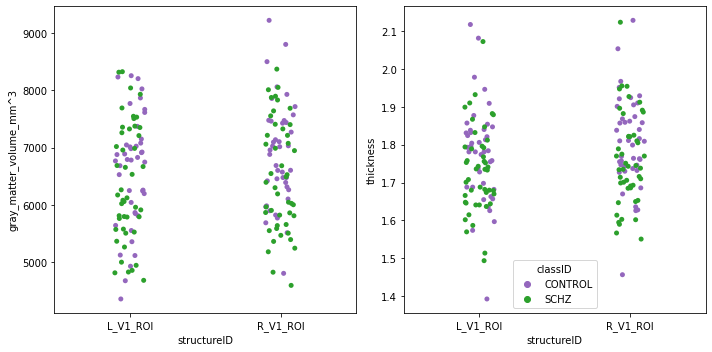

In [378]:
## compute categorical scatter plot for the left and right V1s for gray matter volume and cortical thickness
# create a subplot figure with 1 row and 2 columns
fig, axes = plt.subplots(1,2,figsize=(10,5),sharex=True)

# create a strip plot for each measure
sns.stripplot(x='structureID',y='gray_matter_volume_mm^3',data=v1,hue='classID',palette=groups_colors,ax=axes[0],size=5,legend=False)
sns.stripplot(x='structureID',y='thickness',data=v1,hue='classID',palette=groups_colors,ax=axes[1],size=5)
fig.tight_layout()

It looks like there's a difference in the behavioral measures between our groups! Let's investigate a bit more!

<Axes: xlabel='vr2dr_totalraw', ylabel='Count'>

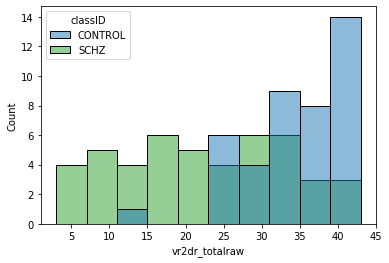

In [171]:
# generate a histogram for each group for the v42dr_totalraw measure
sns.histplot(x='vr2dr_totalraw',hue='classID',data=v1_mean,palette=groups_colors,bins=10)

As we can see from the data, it appears there's a statistically significant difference between our groups in the v42dr_totalraw measure!

## You've now completed your first set of analyses on brainlife.io using the jupyter notebooks!